In [14]:
#import library
import os
import numpy as np
import scipy.io
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [15]:
filePath = '/Users/yamamotokouhei/subjectsData/braindata20221003'
brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']
print(np.shape(brainAdress))

(64,)


In [16]:
# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data65_label2 = list()#label2のデータ
o_data = list()
label_data = list()#labelを結合したデータ
task1_data = list()
task2_data = list()

All_data = list()  # 全データを結合

def Standardization(data): #標準化
    after_data = scipy.stats.zscore(data)
    b = np.average(after_data)
    c = np.var(after_data)
    return after_data

In [17]:
file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
[' EEG_grasping_03-Oct-2022_sub1-1.mat', ' EEG_grasping_03-Oct-2022_sub1-2.mat', ' EEG_grasping_03-Oct-2022_sub1-3.mat', ' EEG_grasping_03-Oct-2022_sub2-1.mat', ' EEG_grasping_03-Oct-2022_sub2-2.mat', ' EEG_grasping_03-Oct-2022_sub2-3.mat', ' EEG_grasping_03-Oct-2022_sub3-2.mat', ' EEG_grasping_03-Oct-2022_sub3-3.mat', ' EEG_grasping_03-Oct-2022_sub4-1.mat', ' EEG_grasping_03-Oct-2022_sub4-2.mat', ' EEG_grasping_03-Oct-2022_sub4-3.mat', 'EEG_grasping_03-Oct-2022_sub3-1.mat']


In [18]:
#label1の設定
file_name1 = [file_name[0],file_name[1],file_name[2]]
file_num1 = len(file_name1)
#label2の設定
file_name2 = [file_name[3],file_name[4],file_name[5]]
file_num2 = len(file_name2)
# 変数など
trial_num = 30
all_trial = len(file_name1)+len(file_name2) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = 1
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
#label2を読み込む
for s in range(file_num2):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name2[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = 2
                o_data = O_Data(eeg, index, label)
                o_data65_label2.append(o_data)
print("data_loading")
print(np.shape(o_data65_label1))
print(np.shape(o_data65_label2))

data_loading
(90,)
(90,)


In [19]:
#chごとの加算平均を求める
ave_task1 = list()
dim_columns = 64
dim_rows = 12000
output = np.full((dim_columns,dim_rows), 0,dtype=np.float64)
print(np.shape(output))
#labelごとのデータを可視化
for n in range(len(file_name1)*trial_num):  # all_trial
    eeg_label1 = np.array(o_data65_label1[n].eeg,dtype=np.float64)  # トライアルnのeeg
    index_label1 = o_data65_label1[n].index  # トライアルnのindex
    rowsize = len(index_label1)
    label1 = o_data65_label1[n].label  # トライアルnのlabel
    output += eeg_label1[0:64,0:12000]
output = output/(len(file_name1)*trial_num)

(64, 12000)


In [20]:
#chごとの加算平均を求める
ave_task2 = list()
dim_columns = 64
dim_rows = 12000
output1 = np.full((dim_columns,dim_rows), 0,dtype=np.float64)
print(np.shape(output1))
#labelごとのデータを可視化
for n in range(len(file_name2)*trial_num):  # all_trial
    eeg_label2 = np.array(o_data65_label2[n].eeg,dtype=np.float64)  # トライアルnのeeg
    
    index_label2 = o_data65_label2[n].index  # トライアルnのindex
    rowsize = len(index_label2)
    label2 = o_data65_label2[n].label  # トライアルnのlabel
    output1 += eeg_label2[0:64,0:12000]
output1 = output1/(len(file_name2)*trial_num)


(64, 12000)


In [21]:
#各データから全体の平均を引くcommon average referance
np.shape(output)
output_all1 = 0
output_all2 = 0
for i in range(64):
    output_all1 += output[i]
    output_all2 += output1[i]
output_all1 = output_all1/64
output_all2 = output_all2/64
for j in range(64):
    output[j] = output[j] - output_all1
    output1[j] = output1[j] - output_all2

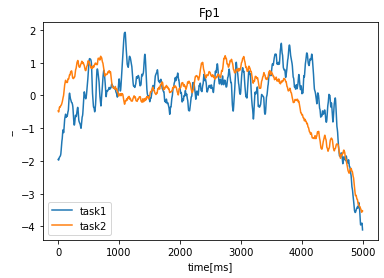

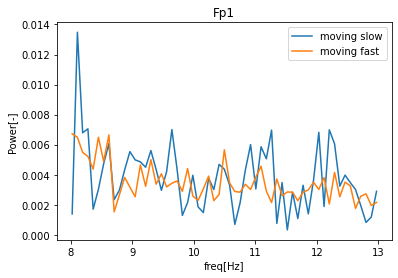

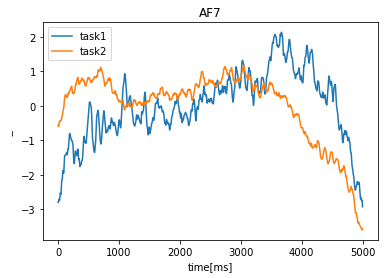

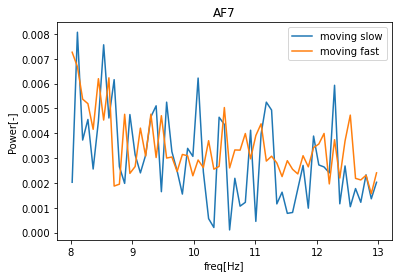

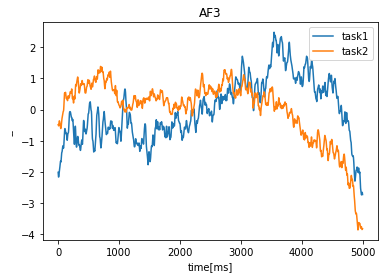

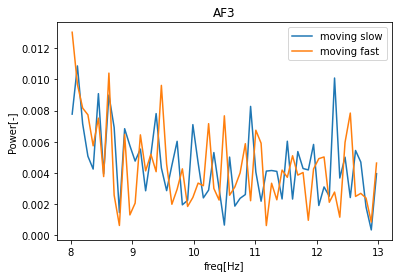

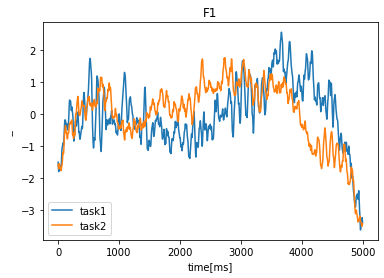

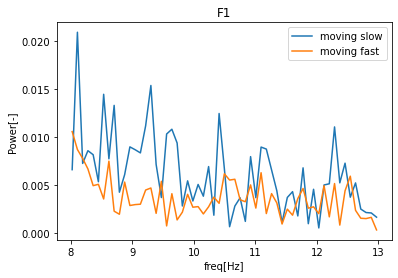

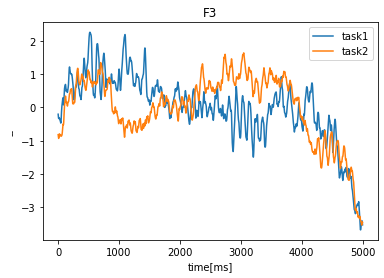

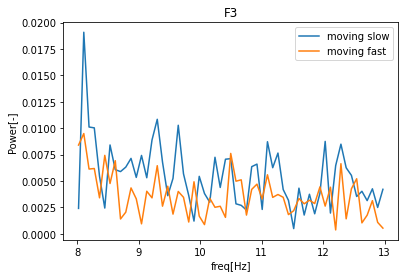

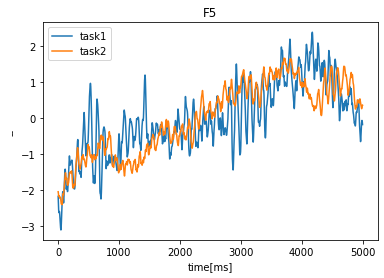

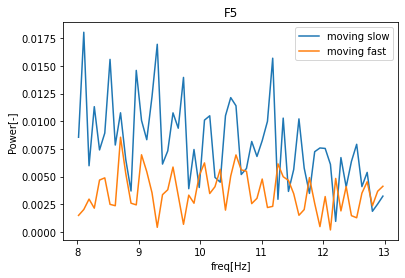

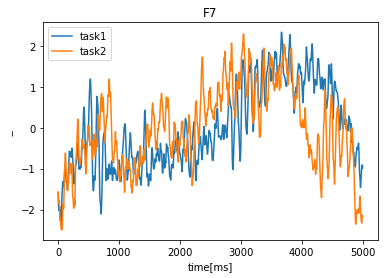

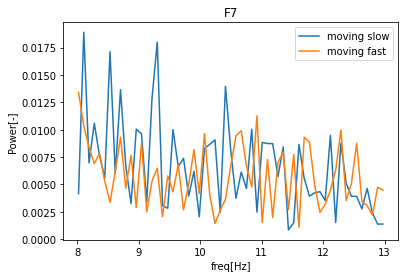

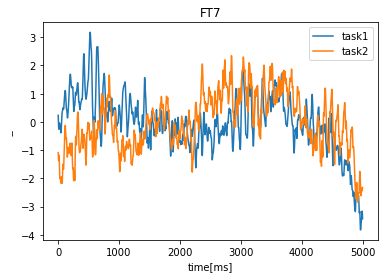

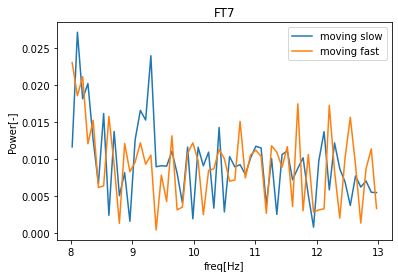

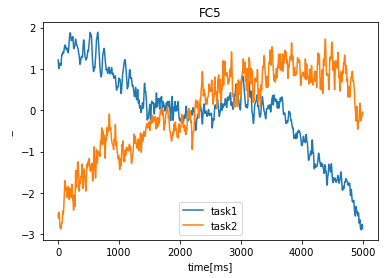

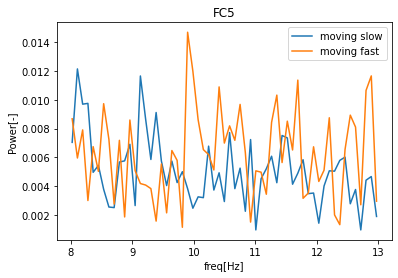

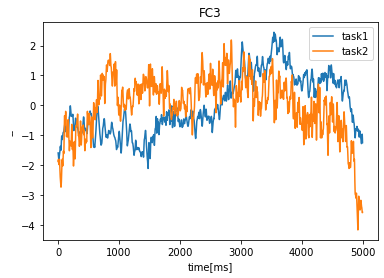

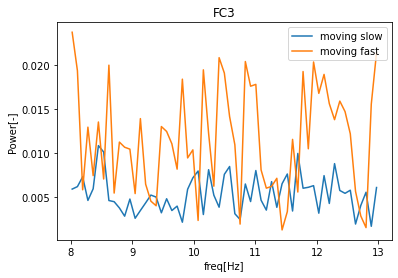

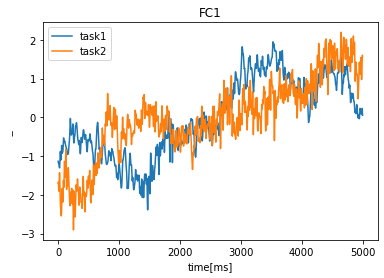

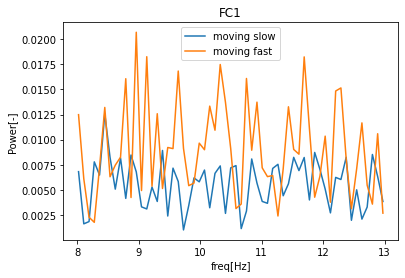

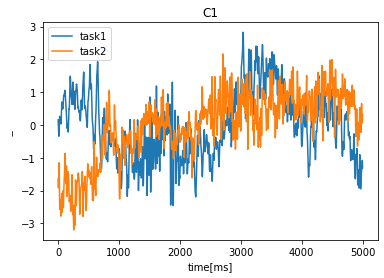

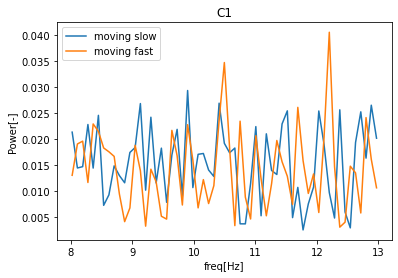

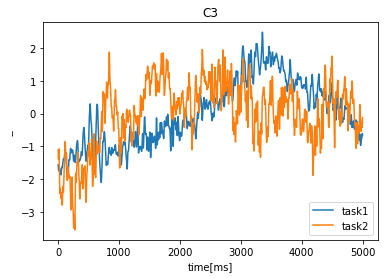

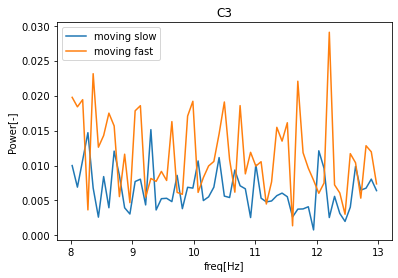

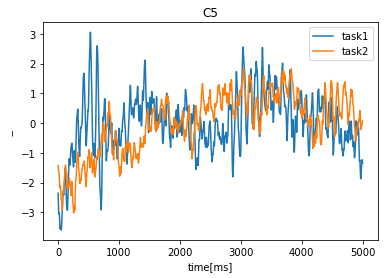

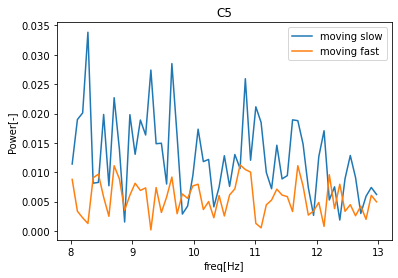

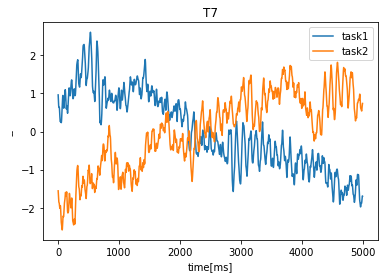

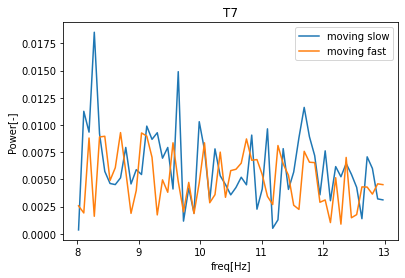

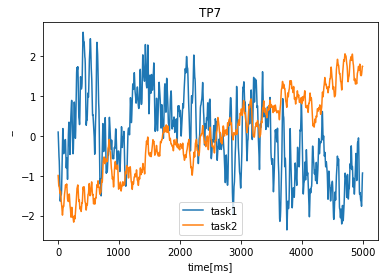

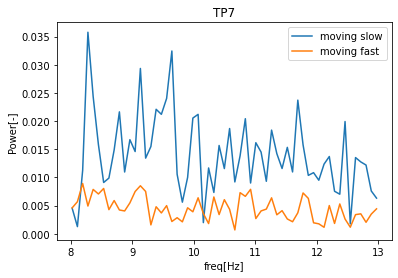

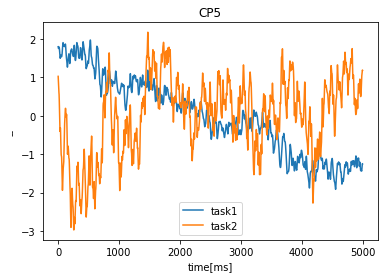

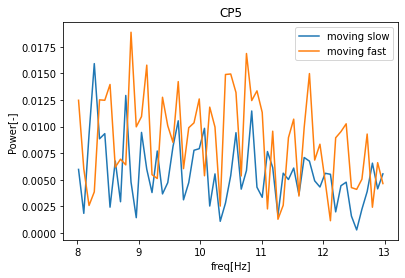

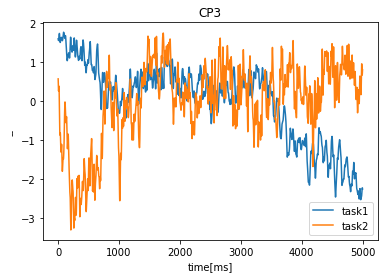

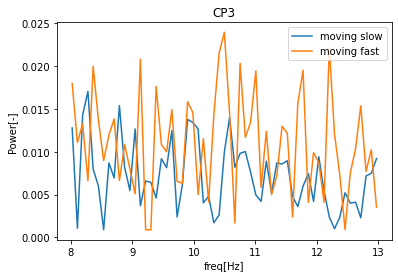

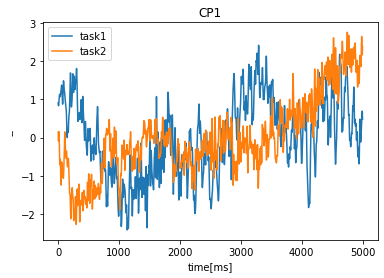

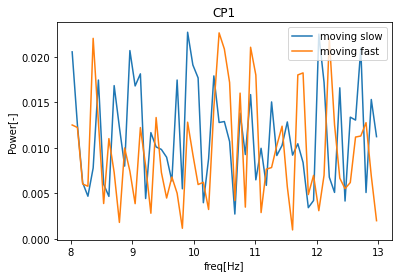

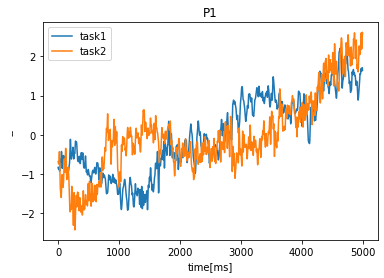

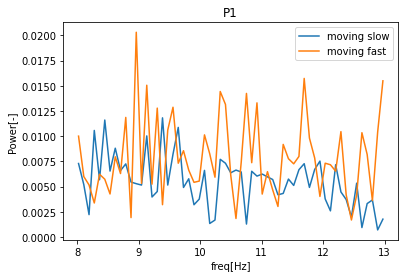

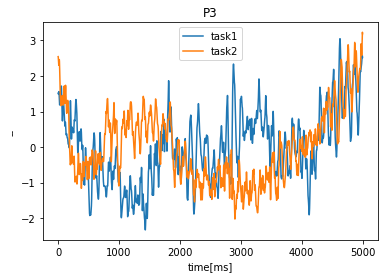

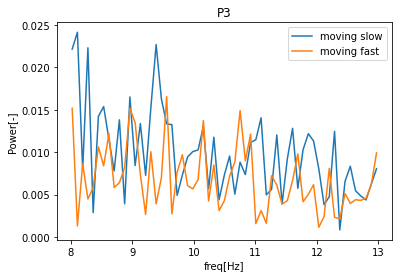

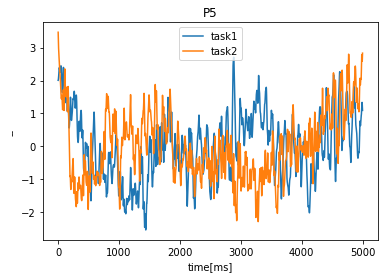

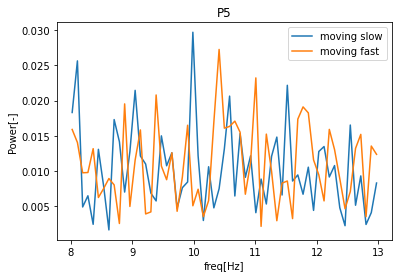

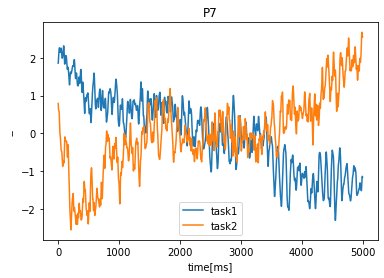

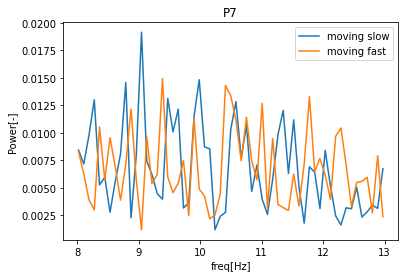

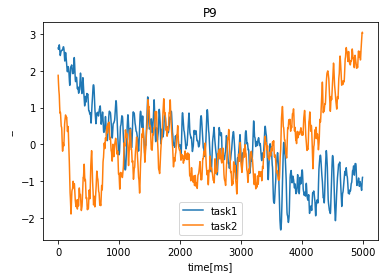

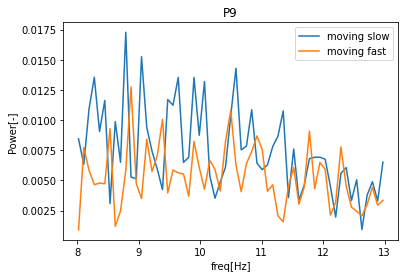

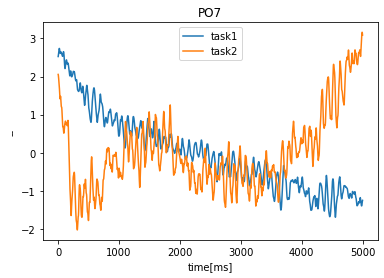

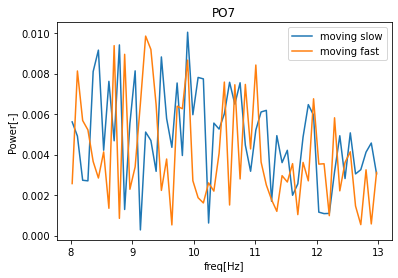

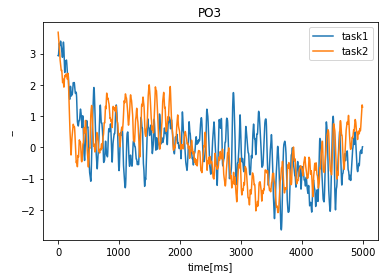

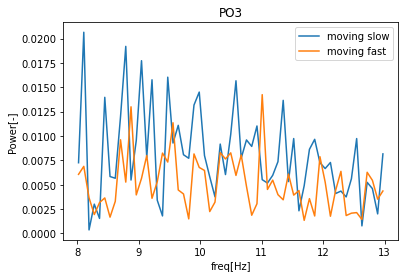

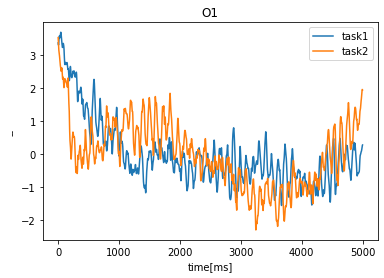

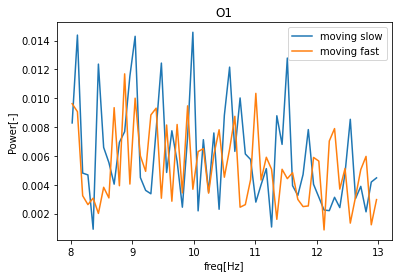

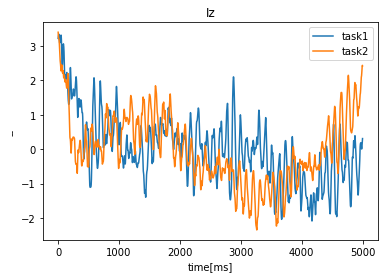

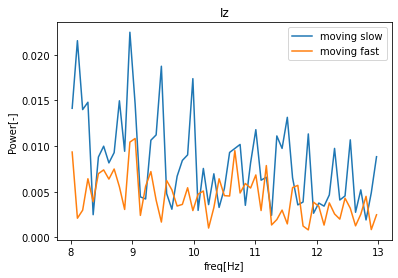

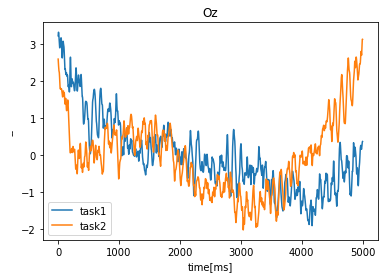

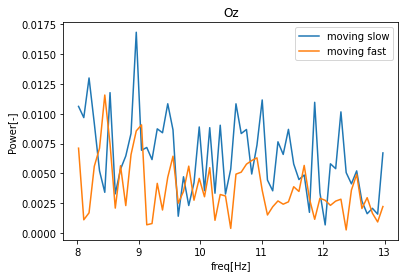

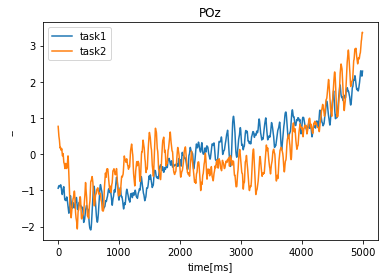

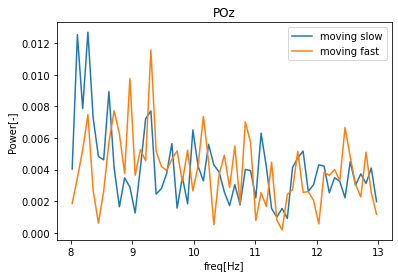

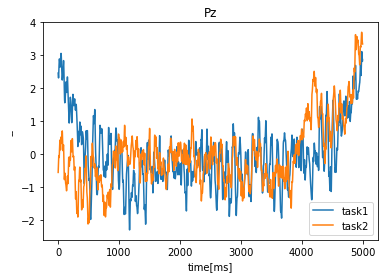

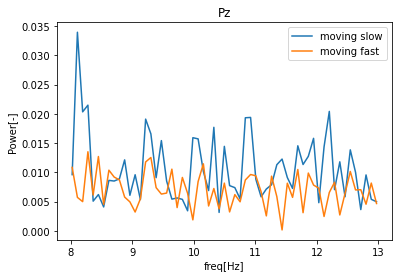

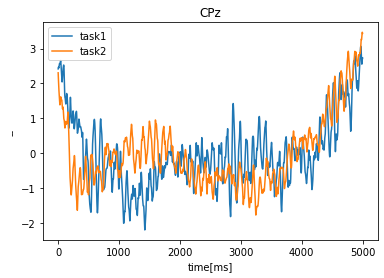

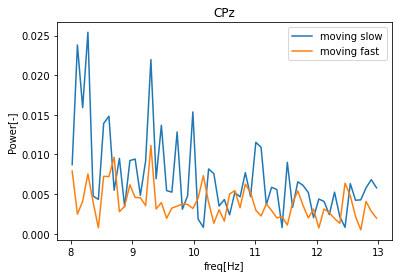

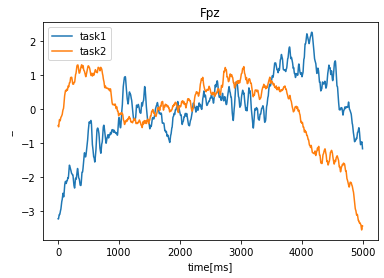

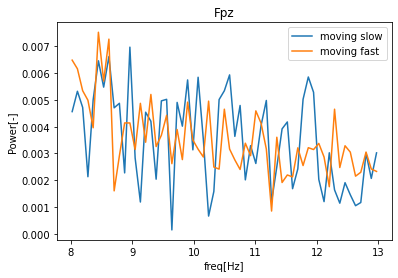

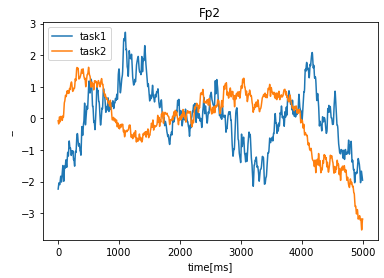

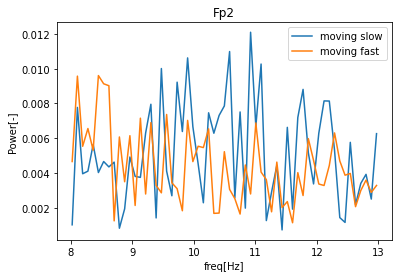

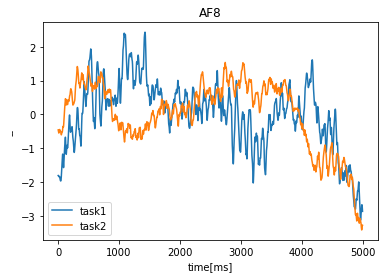

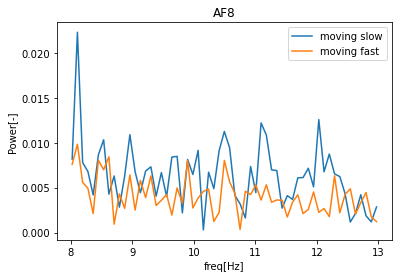

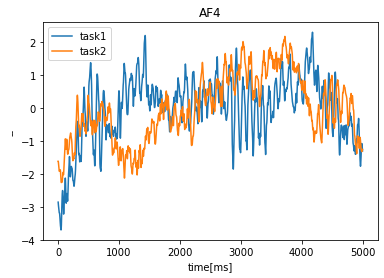

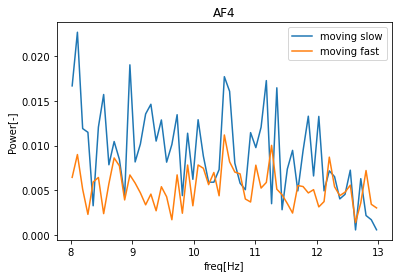

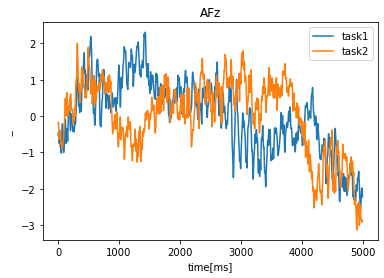

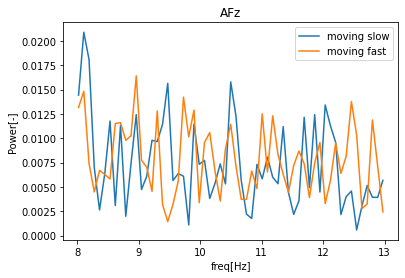

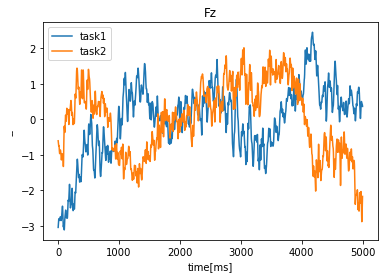

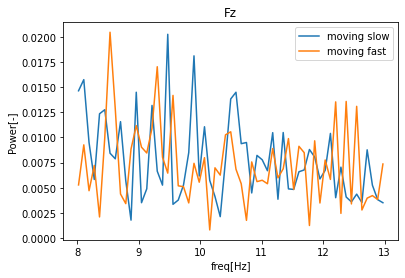

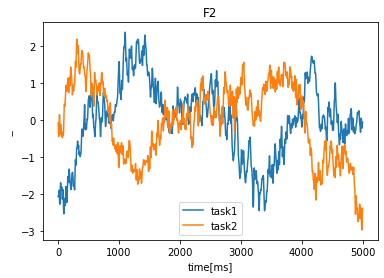

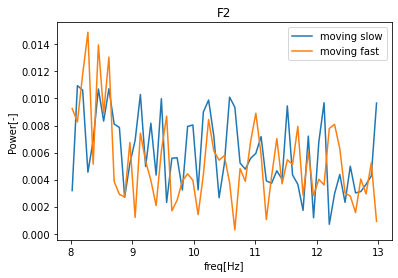

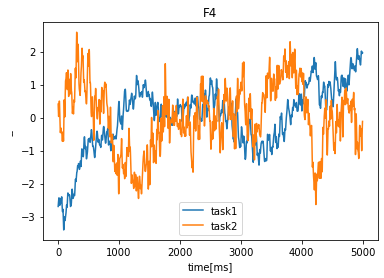

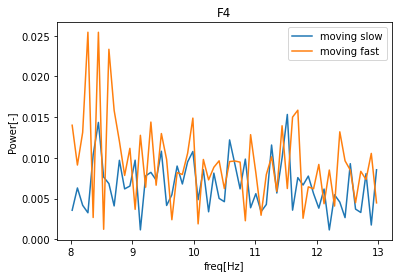

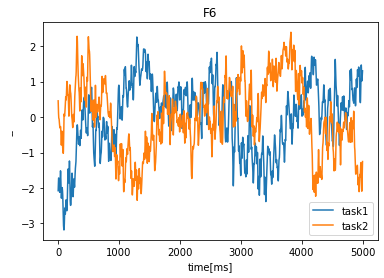

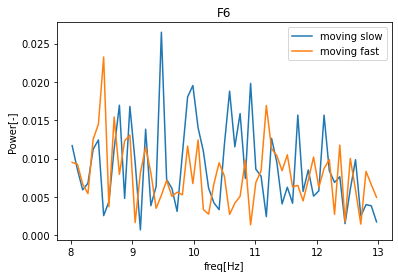

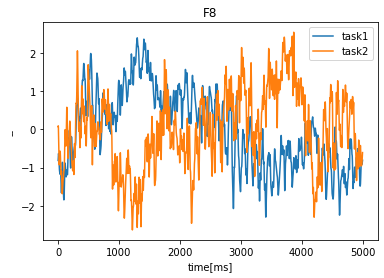

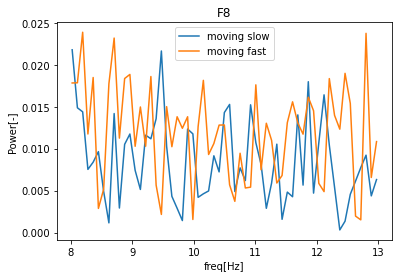

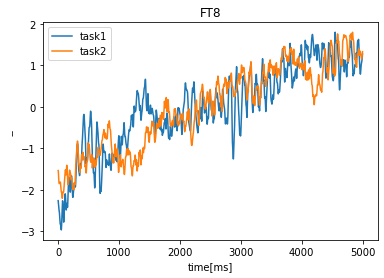

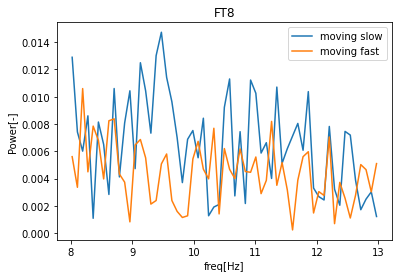

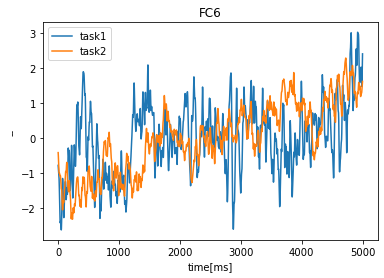

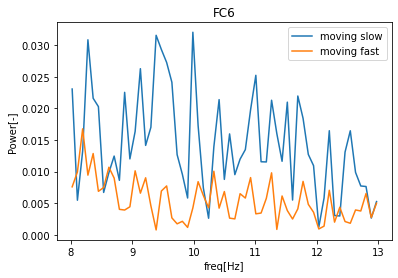

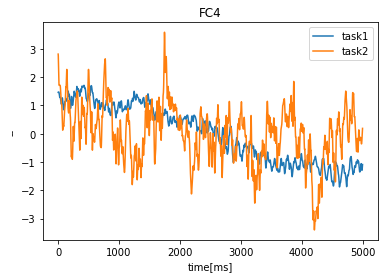

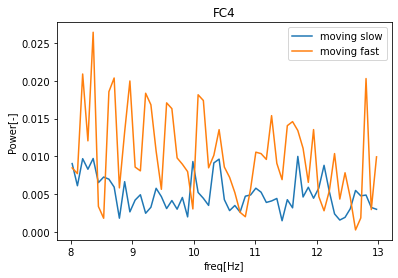

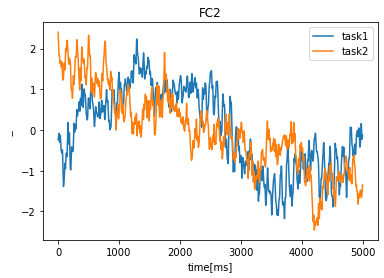

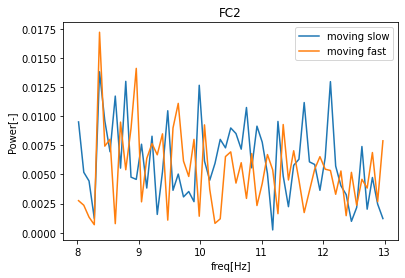

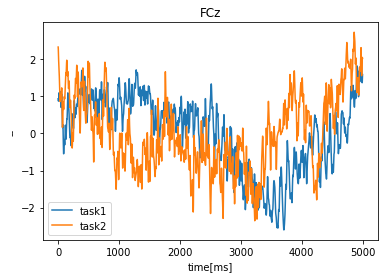

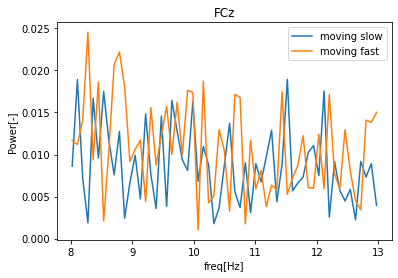

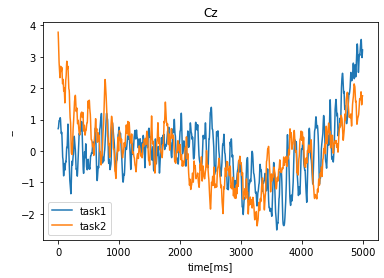

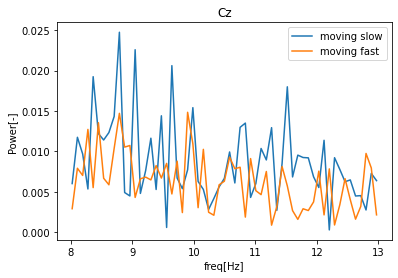

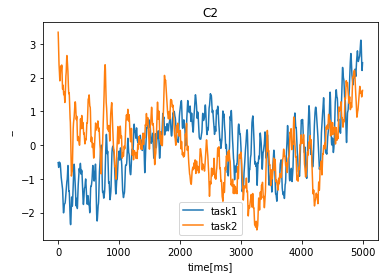

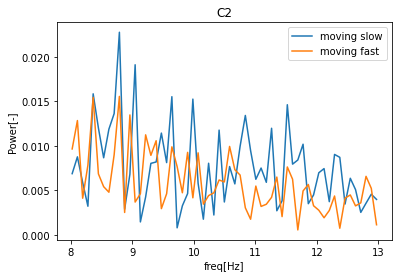

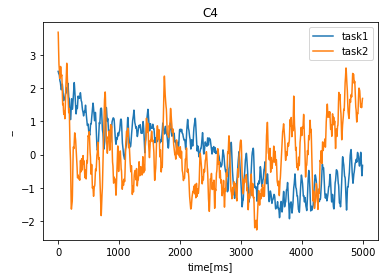

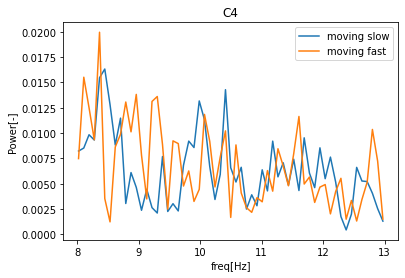

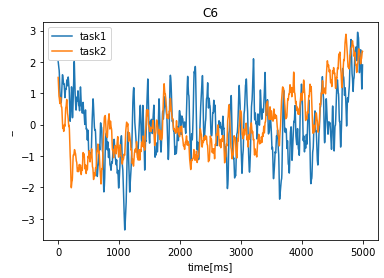

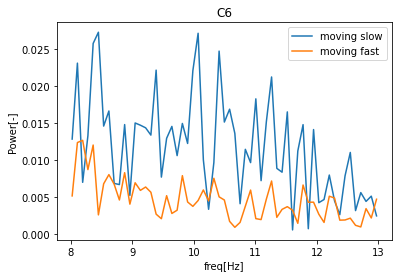

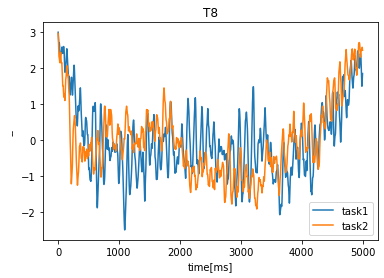

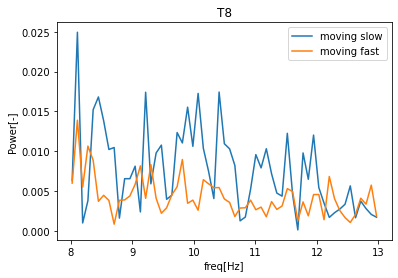

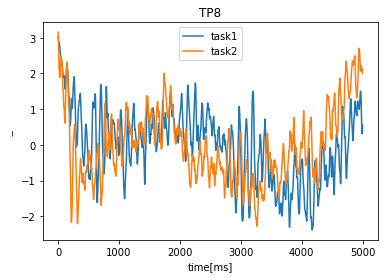

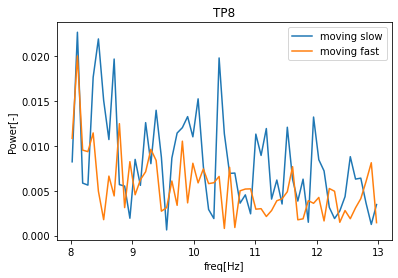

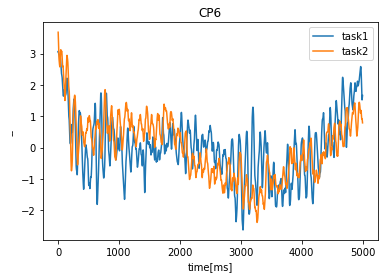

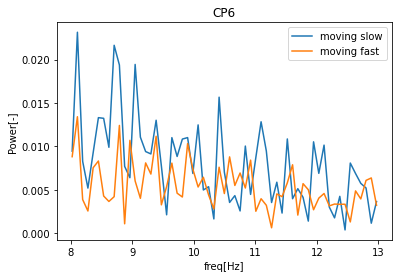

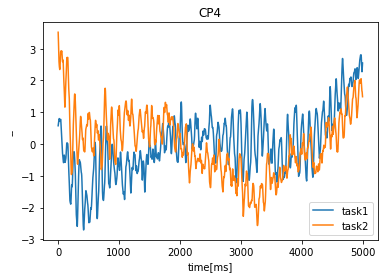

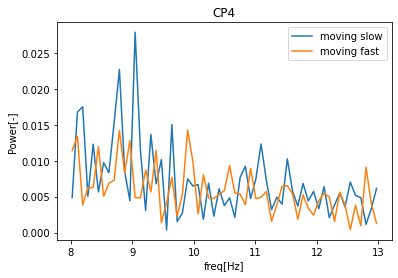

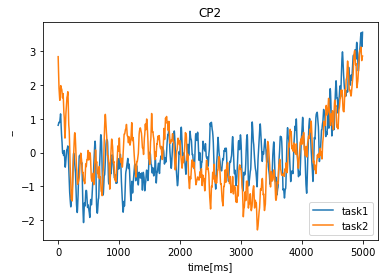

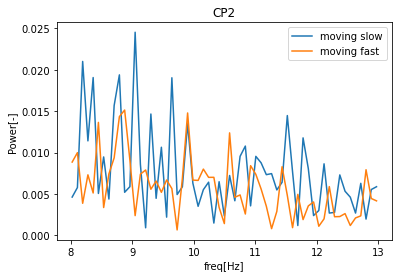

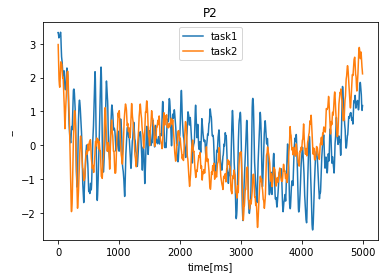

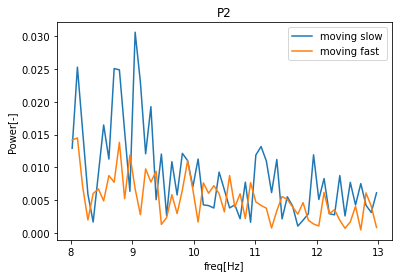

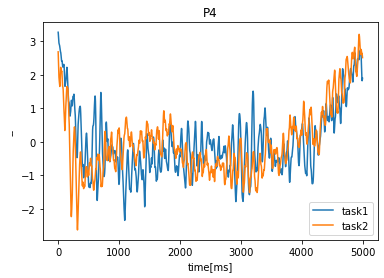

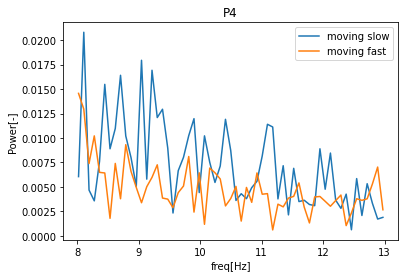

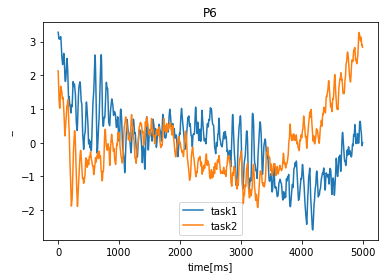

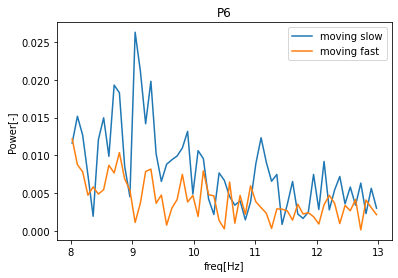

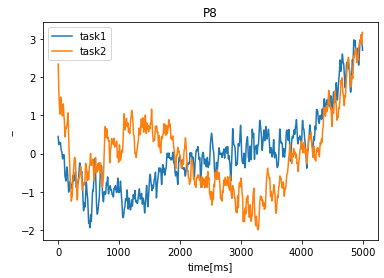

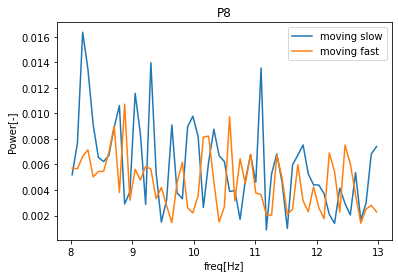

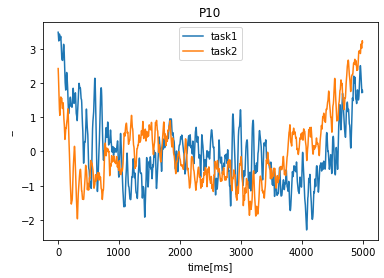

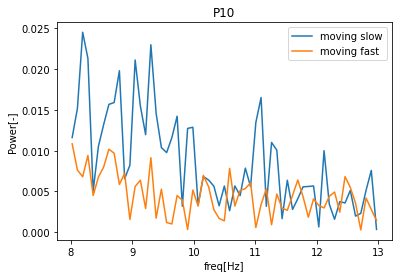

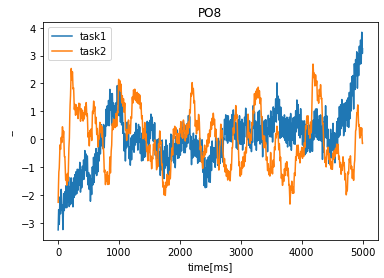

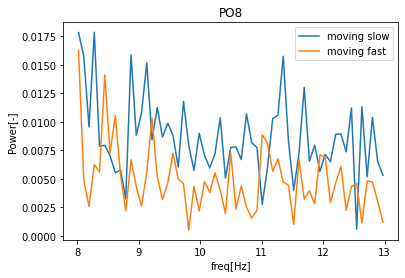

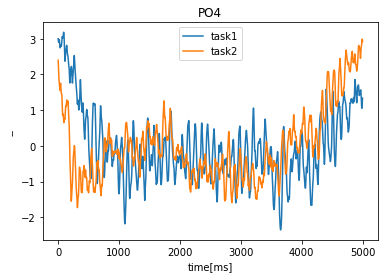

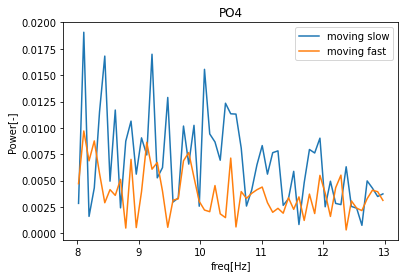

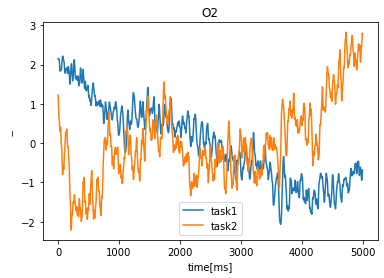

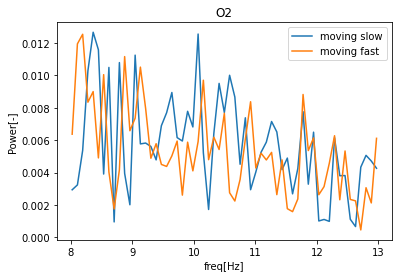

In [40]:
for n in range(64):  # all_channel
    dt = 1/1024
    filter3 = signal.firwin(numtaps=51, cutoff=[5, 50], fs=1024, pass_zero=False)
    y1 = signal.lfilter(filter3, 1, output[n])
    y2 = signal.lfilter(filter3, 1, output1[n])
    outStandard1 = Standardization(y1[7000:])
    outStandard2 = Standardization(y2[7000:])
    F1 = np.fft.fft(outStandard1)
    F2 = np.fft.fft(outStandard2)
    N = 12000
    dt = 1/1024
    t = np.arange(0, N*dt, dt) # 時間軸
    plt.title(brainAdress[n])
    plt.plot(outStandard1,label= 'task1')
    plt.plot(outStandard2,label= 'task2')
    plt.xlabel("time[ms]")
    plt.ylabel("--")
    plt.legend()
    plt.show()
    
    freq = np.fft.fftfreq(N,d=dt) # 周波数軸
    # 振幅スペクトルを計算
    amplitude1 = np.abs(F1)
    amplitude2 = np.abs(F2)
    F_amplitude1 = amplitude1 / N * 2
    F_amplitude1[0] = F_amplitude1[0] / 2
    F_amplitude2 = amplitude2 / N * 2
    F_amplitude2[0] = F_amplitude2[0] / 2

    plt.title(brainAdress[n])
    plt.plot(freq[94:153], F_amplitude1[94:153],label= 'moving slow')
    plt.plot(freq[94:153], F_amplitude2[94:153],label= 'moving fast')
    plt.xlabel("freq[Hz]")
    plt.ylabel("Power[-]")
    plt.legend()
    plt.show()
